In [71]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import image
import random
from skimage import feature
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import scipy
import cv2
from skimage.feature import local_binary_pattern
from sklearn.metrics import accuracy_score
from sklearn.kernel_approximation import Nystroem

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model


In [73]:
%matplotlib inline
# random.seed(42)

In [74]:
target_dict = {'original':0, 'imposter':1}
target_val = [0, 1]

In [75]:
train_data = []
train_labels = []
train_img_name = []

client_train_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\ClientNormalized'
orig_face_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\client_train_normalized.txt'
with open(orig_face_path) as f:
    read_data = f.read()
    
read_data = read_data.split('\n')
read_data.pop(-1)

for line in read_data:
    img_path = os.path.join(client_train_path, line)
    img = image.imread(img_path)
    if img is not None:
        train_data.append(img)
        train_labels.append(0)
        train_img_name.append('Original - ' + line)
    
    
imposter_train_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\ImposterNormalized'
imposter_face_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\imposter_train_normalized.txt'
with open(imposter_face_path) as f:
    read_img_data = f.read()
    
read_img_data = read_img_data.split('\n')    
read_img_data.pop(-1)

for line in read_img_data:
    img_path = os.path.join(imposter_train_path, line)
    img = image.imread(img_path)
    if img is not None:
        train_data.append(img)
        train_labels.append(1)
        train_img_name.append('Imposter - ' + line)

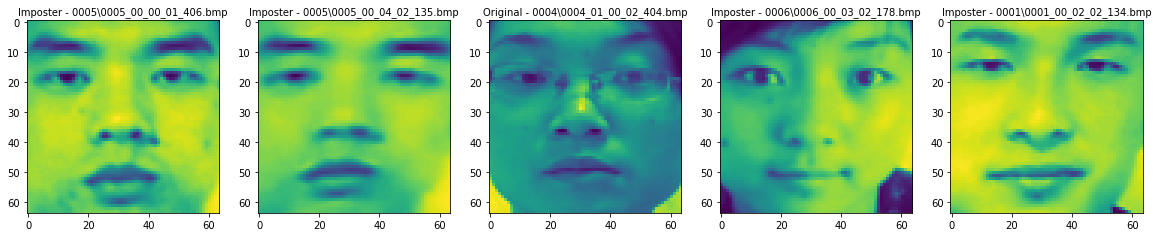

In [76]:
plt.figure(figsize=(20, 20))
for i in range(5):
    id = random.randrange(len(train_data))
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[id])
    plt.title(train_img_name[id], fontsize=10)

In [77]:
print(len(train_data), len(read_data), len(read_img_data)) #total, original, imposter

3491 1743 1748


In [78]:
test_data = []
test_labels = []
test_img_name = []

client_test_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\ClientNormalized'
orig_face_test_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\client_test_normalized.txt'

with open(orig_face_test_path) as f:
    read_test_data = f.read()
    
read_test_data = read_test_data.split('\n')
read_test_data.pop(-1)

for line in read_test_data:
    img_path = os.path.join(client_test_path, line)
    img = image.imread(img_path)
    if img is not None:
        test_data.append(img)
        test_labels.append(0)
        test_img_name.append('Original - '+line)
    
    
    
imposter_test_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\ImposterNormalized'
imposter_face_test_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\imposter_test_normalized.txt'

with open(imposter_face_test_path) as f:
    read_img_test_data = f.read()
    
read_img_test_data = read_img_test_data.split('\n')   
read_img_test_data.pop(-1)

for line in read_img_test_data:
    img_path = os.path.join(imposter_test_path, line)
    img = image.imread(img_path)
    if img is not None:
        test_data.append(img)
        test_labels.append(1)
        test_img_name.append('Imposter - ' + line)

In [89]:
print(len(test_data), len(read_test_data), len(read_img_test_data))  #total, original, imposter

9123 3362 5761


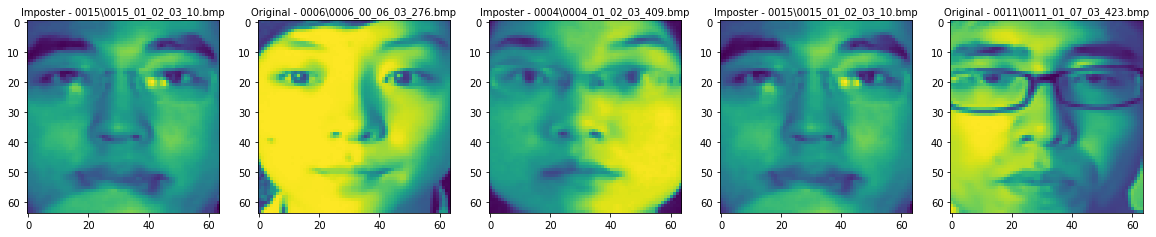

In [90]:
plt.figure(figsize=(20, 20))
for i in range(5):
    id = random.randrange(len(test_data))
    plt.subplot(1, 5, i+1)
    plt.imshow(test_data[id])
    plt.title(test_img_name[id], fontsize=10)

In [91]:
import pandas as pd
f = pd.Index(train_labels)
f.value_counts()

1    1748
0    1743
dtype: int64

In [92]:
f_ = pd.Index(test_labels)
f_.value_counts()

1    5761
0    3362
dtype: int64

In [93]:
img_h, img_w = 64, 64
split_width = 31
split_height = 31
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points


X_points = start_points(img_w, split_width)
Y_points = start_points(img_h, split_height)

In [94]:
def splitImage_appendHist(img):
    long_histogram_list = []

    for i in Y_points:
        for j in X_points:
            split = img[i:i+split_height, j:j+split_width]
            lbp_image=local_binary_pattern(split,8,1,method='nri_uniform')
            hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
            long_histogram_list.extend(hist)
#             cv2.imwrite('{}_{}.{}'.format(name, count, frmt), split)
#             count += 1


    lbp_image=local_binary_pattern(img,8,2,method='nri_uniform')
    hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
    long_histogram_list.extend(hist)


    lbp_image=local_binary_pattern(img,16,2,method='nri_uniform')
    hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
    long_histogram_list.extend(hist)

    long_histogram = np.array(long_histogram_list)
    return long_histogram

In [95]:
hist_train_data=[]
for img in train_data:
    hist = splitImage_appendHist(img)
    hist_train_data.append(hist)

In [109]:
model = LinearSVC(C = 100.0, random_state = 42)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=300)
data_transformed = feature_map_nystroem.fit_transform(hist_train_data)
model.fit(hist_train_data, train_labels)
model.score(hist_train_data, train_labels)

C:\Users\AASTHA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0

[1, 1, 1, 1, 1]


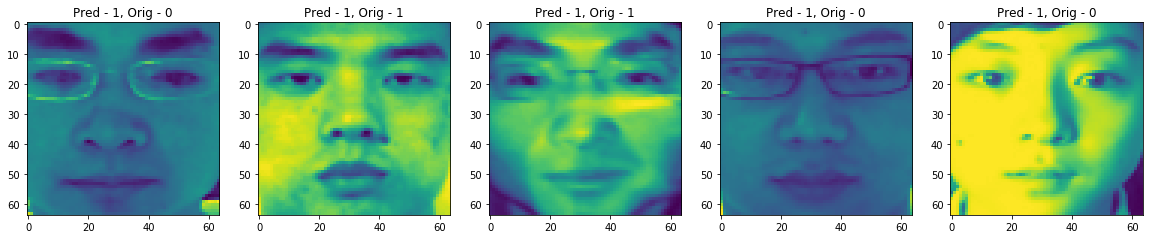

In [110]:
plt.figure(figsize = (20, 20))

id_list = random.sample(range(0, len(test_data)), 5)
test_pred = []
for id, i in enumerate(id_list):
    hist = splitImage_appendHist(test_data[i])
    pred = model.predict(hist.reshape(1, -1))
    test_pred.extend(pred)
    plt.subplot(1, 5, id+1)
    plt.title('Pred - {}, Orig - {}'.format(pred[0], test_labels[i]))
    plt.imshow(test_data[i])
    
print(test_pred)

In [111]:
test_pred = []
for i in range(len(test_data)):
    hist = splitImage_appendHist(test_data[i])
    pred = model.predict(hist.reshape(1, -1))
    test_pred.extend(pred)
print(len(test_pred))

9123


In [112]:
all_ones = [1]*len(test_labels)
len(all_ones)
print(accuracy_score(test_labels, all_ones))

0.6314808725200044


In [113]:
accuracy = accuracy_score(test_pred, test_labels)
print(accuracy)

0.6314808725200044


Experiment : Below Cells is for one image only

In [ ]:
some_img_path = r'C:\Users\AASTHA\One step Closer\Face Spoofing\Datasets\NUAA\NormalizedFace\ClientNormalized\0001\0001_00_00_01_0.bmp'
some_img = plt.imread(some_img_path)
plt.imshow(some_img)

In [ ]:

lbp_image=local_binary_pattern(some_img,8,1,method='nri_uniform')
hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
histogram=scipy.stats.itemfreq(lbp_image)
print(hist.shape)
# for (x, y) in zip(histogram, hist):
#     print('x = {}, y = {}'.format(x, y))

In [ ]:
(n, bins, patches) = plt.hist(lbp_image, bins=59, label='hst')
print(bins)

In [ ]:
path_to_img = some_img_path
img = plt.imread(path_to_img)
img_h, img_w = img.shape
split_width = 31
split_height = 31


def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points


X_points = start_points(img_w, split_width)
Y_points = start_points(img_h, split_height)

count = 0
name = 'splitted'
frmt = 'jpeg'

long_histogram_list = []
flag = True
for i in Y_points:
    for j in X_points:
        split = img[i:i+split_height, j:j+split_width]
        lbp_image=local_binary_pattern(split,8,1,method='nri_uniform')
        hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
        long_histogram_list.extend(hist)
#         cv2.imwrite('{}_{}.{}'.format(name, count, frmt), split)
        count += 1


lbp_image=local_binary_pattern(img,8,2,method='nri_uniform')
hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
long_histogram_list.extend(hist)


lbp_image=local_binary_pattern(img,16,2,method='nri_uniform')
hist, _ = np.histogram(lbp_image.ravel(), bins = int(lbp_image.max())+1, range =(0, lbp_image.max()))
long_histogram_list.extend(hist)

long_histogram = np.array(long_histogram_list)
print(long_histogram.shape)

In [ ]:
for i in range(count):
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread('splitted_{}.jpeg'.format(i)))
#     print(plt.imread('splitted_{}.jpeg'.format(i)).shape)

In [ ]:
img.shape

In [ ]:
from tqdm import tqdm 
import time 
x = 1
for i in tqdm (range (100), desc="Loading…", ascii=False, ncols=75): 
    time.sleep(0.01) 

print("Complete.") 
